In [ ]:
#import sys
#path_to_drive_colab_notebooks = '/content/drive/MyDrive/wbk/code'
#sys.path.append(path_to_drive_colab_notebooks)
#from important_functions_wbk import *

### Importing the libraries:

In [ ]:
!pip install keras-tuner
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import InputLayer, Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import shuffle
import plotly.express as px

from numpy import mean
from numpy import std
from numpy import dstack
from keras.utils import to_categorical

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 chenge this function to convert sequences which has 3 feature input and categorical_class as output


### function to create sequences:

In [ ]:
def to_sequences(df, seq_size=128, seq_stride=128, feature='CURRENT|6', y_type='wear_class', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    x2_values = []
    x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df['CURRENT|6']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])

    for index, data in enumerate(df['CURRENT|1']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x2_values.append(data[i:(i+seq_size)])

    for index, data in enumerate(df['CURRENT|2']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x3_values.append(data[i:(i+seq_size)])

    
    if mix=='ON':
      x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly = shuffle(x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        'CURRENT|6':x1_values,
        'CURRENT|1':x2_values,
        'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values, x2_values, x3_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

In [ ]:
def to_sequences_1_feature(df, seq_size=128, seq_stride=128, y_type='wear_class', feature='CURRENT|6', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    #x2_values = []
    #x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df[feature]):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])
    
    if mix=='ON':
      x1_values, file_index, wear_class, is_anomaly = shuffle(x1_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        feature:x1_values,
        #'CURRENT|1':x2_values,
        #'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

# Data Preparation:

### Json Structure:

tool wear data from the experiment is exported from the milling machine to json files. 
Each json file has the following structure: it contains mainly two parts: 'Header' and 'Payload'

In the 'Header' dict 'SignalListHFData' dict contains  all labels of the 'cutting force' parameters, and this are the title of our features too. 

In [ ]:
import json
data_dir = '/content/drive/MyDrive/wbk/tool_wear_data'
filename = 'tool_d_16_damage_0_1.json'
tool = 2
tool_diameter = 16
damage_teeth = '0_1'
is_anomaly = False

with open(os.path.join(data_dir, filename)) as f:
  data = json.load(f)

df1 = pd.DataFrame.from_dict(data['Header']['SignalListHFData'])
df1 = df1.T
df1

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
Name,Cycle,Load,Load,Load,Load,Load,Load,ActualAxisPosition,ActualAxisPosition,ActualAxisPosition,...,Encoder1Position,Encoder1Position,Encoder1Position,Encoder1Position,Encoder2Position,Encoder2Position,Encoder2Position,Encoder2Position,Encoder2Position,Encoder2Position
Type,INTEGER,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,...,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE,DOUBLE
Axis,CYCLE,X1,Y1,Z1,C1,B1,SP1,X1,Y1,Z1,...,Z1,C1,B1,SP1,X1,Y1,Z1,C1,B1,SP1
Address,CYCLE,LOAD|1,LOAD|2,LOAD|3,LOAD|4,LOAD|5,LOAD|6,ENC_POS|1,ENC_POS|2,ENC_POS|3,...,ENC1_POS|3,ENC1_POS|4,ENC1_POS|5,ENC1_POS|6,ENC2_POS|1,ENC2_POS|2,ENC2_POS|3,ENC2_POS|4,ENC2_POS|5,ENC2_POS|6


#### Why 92 Columns?

We have recorded quantities: Load, ActualAxisPosition, Torque, ControlDiff2, CommandedAxisPosition, **Current**, ControlDiff, ControlPos, VelocityFeedForward, Power, CountourDeviation, CommandedSpeed, TorqueFeedForward, Encoder1Position, Encoder2Position 

So **15 quantities** and **each** have **6 axis** (X1, Y1, Z1, C1, B1, SP1).

15x6 = 90

**Plus 2** columns of 'Cycle' and 'Synchronuous Action variable'

thus, we have total **92** columns.

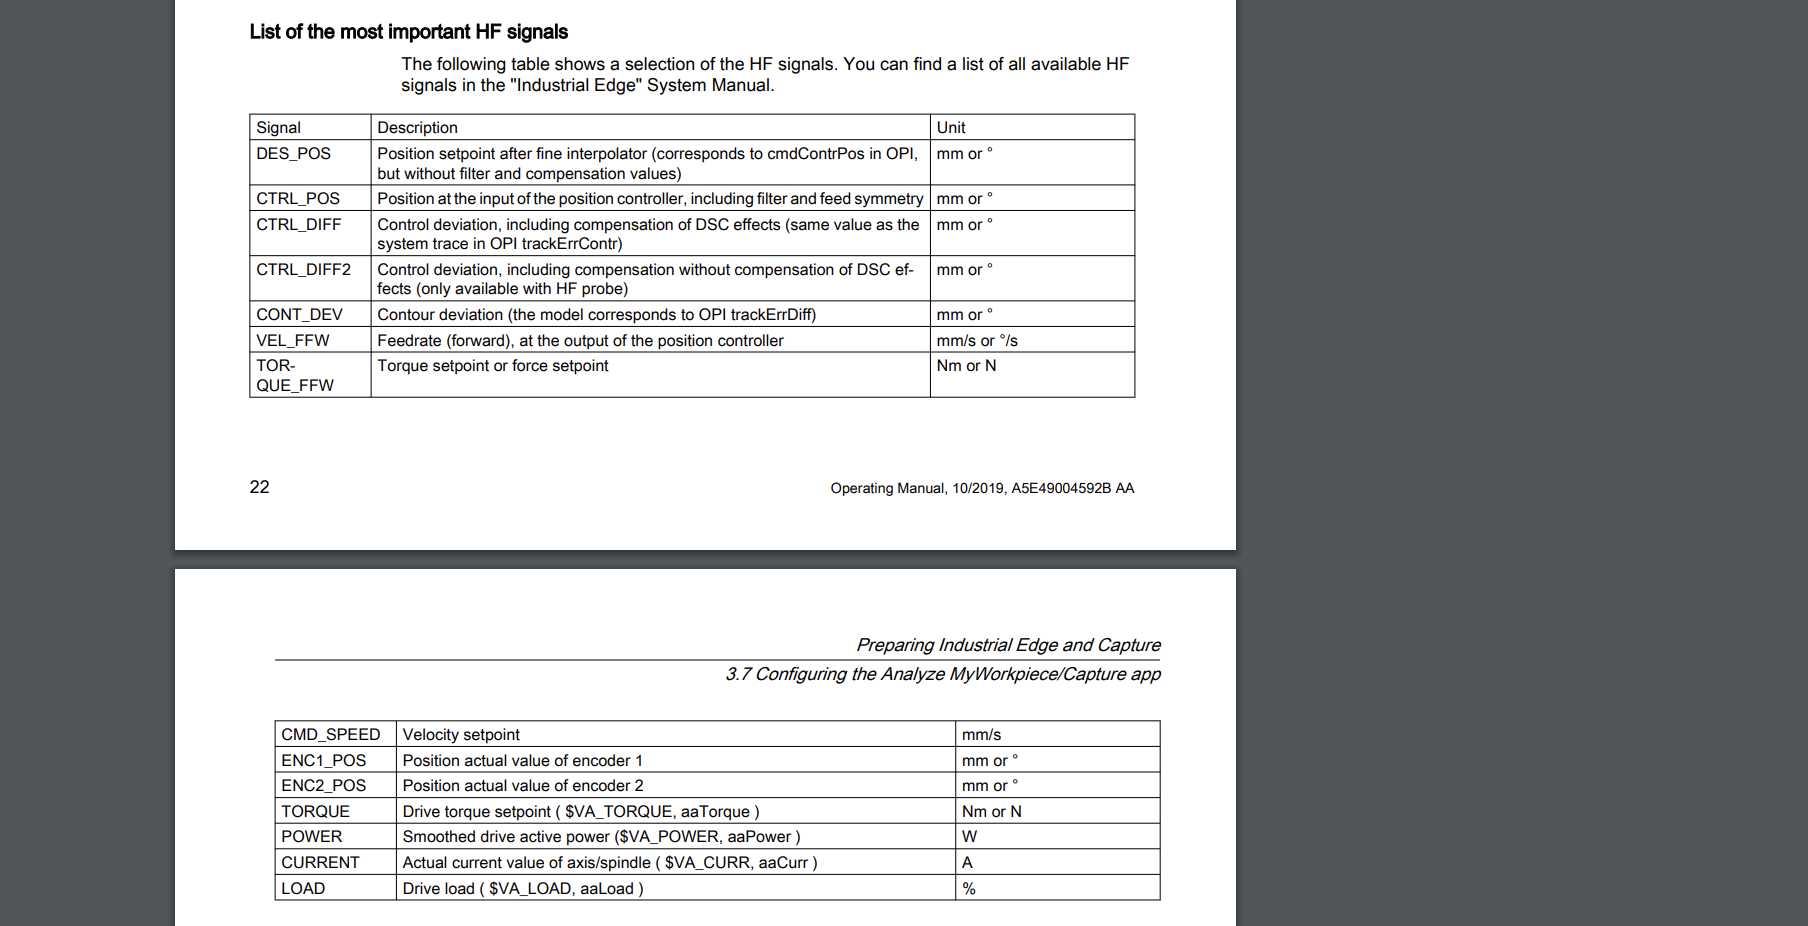

Out of that main required column is '**current**' data

In [ ]:
df2 = pd.DataFrame.from_dict(data['Payload'])
df2

,HFData,HFCallEvent,HFBlockEvent
0,"[[4259501, 1.055908, 2.575684, 21.417236, None...",NaN,NaN
1,"[[4259602, 1.055908, 2.606201, 21.447754, None...",NaN,NaN
2,"[[4259703, 0.98877, 2.56958, 21.411133, None, ...",NaN,NaN
3,"[[4259804, 0.98877, 2.606201, 21.44165, None, ...",NaN,NaN
4,"[[4259905, 0.970459, 2.618408, 21.478271, None...",NaN,NaN
...,...,...,...
2231,"[[4396281, 1.78833, 1.147461, 21.411133, None,...",NaN,NaN
2232,"[[4396379, 1.715088, 3.265381, 21.636963, None...",NaN,NaN
2233,"[[4396481, 0.897217, 3.588867, 21.789551, None...",NaN,NaN
2234,NaN,NaN,"{'HFProbeCounter': 4396565, 'Channel': 1, 'See..."


We do have NaN values in HFData which can create problem so lets clear all the NaN from HFData

In [ ]:
df3 = df2.dropna(subset=['HFData']) 
print('{} rows has NaN values in "HFData", hence removed.'.format(len(df2)-len(df3)))

216 rows has NaN values in "HFData", hence removed.


Now We can extract each files data from the 'Payload''HFData' part of the json and can have headers from the ['Header']['SignalListHFData'] part

In [ ]:
df4 = pd.DataFrame(df3.explode(['HFData'])['HFData'].to_list(), columns=df1.iloc[3])
df4 = df4[['CYCLE','CURRENT|1', 'CURRENT|2','CURRENT|6']]
df4.insert(0, 'tool', tool)
df4.insert(1, 'tool_diameter', tool_diameter)
df4.insert(2, 'damage_teeth', damage_teeth)
df4.insert(3, 'is_anomaly', is_anomaly)
df4

Address,tool,tool_diameter,damage_teeth,is_anomaly,CYCLE,CURRENT|1,CURRENT|2,CURRENT|6
0,2,16,0_1,False,4259501,0.194824,-0.469971,0.000000
1,2,16,0_1,False,4259502,0.198242,-0.461426,0.000000
2,2,16,0_1,False,4259503,0.191406,-0.463135,0.000000
3,2,16,0_1,False,4259504,0.196533,-0.463135,0.000000
4,2,16,0_1,False,4259505,0.193115,-0.463135,0.000000
...,...,...,...,...,...,...,...,...
137077,2,16,0_1,False,4396578,0.659668,0.249512,-0.346436
137078,2,16,0_1,False,4396579,0.733154,0.239258,-0.346436
137079,2,16,0_1,False,4396580,0.763916,0.222168,-0.346436
137080,2,16,0_1,False,4396581,0.786133,0.181152,-0.346436


### combining all the files into one dataframe

In [ ]:
def create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly):
  with open(os.path.join(data_dir, filename)) as f:
    data = json.load(f)
  df1 = pd.DataFrame.from_dict(data['Header']['SignalListHFData'])
  df1 = df1.T
  df2 = pd.DataFrame.from_dict(data['Payload'])
  df3 = df2.dropna(subset=['HFData'])
  df4 = pd.DataFrame(df3.explode(['HFData'])['HFData'].to_list(), columns=df1.iloc[3])
  df4 = df4[['CYCLE','CURRENT|1', 'CURRENT|2','CURRENT|6']]
  df4.insert(0, 'file_no', file_no)
  df4.insert(1, 'filename', filename)
  df4.insert(2, 'tool', tool)
  df4.insert(3, 'tool_diameter', tool_diameter)
  df4.insert(4, 'damage_teeth', damage_teeth)
  df4.insert(5, 'is_anomaly', is_anomaly)
  return df4

In [ ]:
import json
data_dir = '/content/drive/MyDrive/wbk/tool_wear_data'

In [ ]:
filename = 'tool_d_12_damage_0_1.json'
file_no = 1
tool = 1
tool_diameter = 12
damage_teeth = '0_1'
is_anomaly = False
combined_df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)

filename = 'tool_d_12_damage_0_2_1.json'
file_no = 2
tool = 1
tool_diameter = 12
damage_teeth = '0_2_1'
is_anomaly = False
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_12_damage_0_2_2.json'
file_no = 3
tool = 1
tool_diameter = 12
damage_teeth = '0_2_2'
is_anomaly = False
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_12_damage_1.json'
file_no = 4
tool = 1
tool_diameter = 12
damage_teeth = '1'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_12_damage_2.json'
file_no = 5
tool = 1
tool_diameter = 12
damage_teeth = '2'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_12_damage_3.json'
file_no = 6
tool = 1
tool_diameter = 12
damage_teeth = '3'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

In [ ]:
filename = 'tool_d_16_damage_0_1.json'
file_no = 7
tool = 2
tool_diameter = 16
damage_teeth = '0_1'
is_anomaly = False
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_16_damage_0_2.json'
file_no = 8
tool = 2
tool_diameter = 16
damage_teeth = '0_2'
is_anomaly = False
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_16_damage_1.json'
file_no = 9
tool = 2
tool_diameter = 16
damage_teeth = '1'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_16_damage_2.json'
file_no = 10
tool = 2
tool_diameter = 16
damage_teeth = '2'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_16_damage_3.json'
file_no = 11
tool = 2
tool_diameter = 16
damage_teeth = '3'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

In [ ]:
filename = 'tool_d_20_damage_0_1.json'
file_no = 12
tool = 3
tool_diameter = 20
damage_teeth = '0_1'
is_anomaly = False
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_20_damage_0_2.json'
file_no = 13
tool = 3
tool_diameter = 20
damage_teeth = '0_2'
is_anomaly = False
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_20_damage_1.json'
file_no = 14
tool = 3
tool_diameter = 20
damage_teeth = '1'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_20_damage_2.json'
file_no = 15
tool = 3
tool_diameter = 20
damage_teeth = '2'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

filename = 'tool_d_20_damage_3.json'
file_no = 16
tool = 3
tool_diameter = 20
damage_teeth = '3'
is_anomaly = True
df = create_tool_df(file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly)
combined_df = pd.concat([combined_df, df])

In [ ]:
combined_df = combined_df.reset_index(drop=True)
combined_df

SAVE combined_df to FOLDER

In [ ]:
combined_df.to_csv('/content/drive/MyDrive/wbk/tool_wear_data/all_tool_wear_current_data.csv')

read and load the same csv file to dataframe:

In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/all_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'is_anomaly':bool})

### **view combined data stats:**

In [ ]:
combined_df.groupby(['file_no', 'filename', 'tool','tool_diameter','damage_teeth','is_anomaly']).count()

,,,,,,Unnamed: 0,CYCLE,CURRENT|1,CURRENT|2,CURRENT|6
file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly,,,,,
1,tool_d_12_damage_0_1.json,1,12,0_1,False,60202,60202,60202,60202,60202
2,tool_d_12_damage_0_2_1.json,1,12,0_2_1,False,325,325,325,325,325
3,tool_d_12_damage_0_2_2.json,1,12,0_2_2,False,140091,140091,140091,140091,140091
4,tool_d_12_damage_1.json,1,12,1,True,57987,57987,57987,57987,57987
5,tool_d_12_damage_2.json,1,12,2,True,56954,56954,56954,56954,56954
6,tool_d_12_damage_3.json,1,12,3,True,60886,60886,60886,60886,60886
7,tool_d_16_damage_0_1.json,2,16,0_1,False,137082,137082,137082,137082,137082
8,tool_d_16_damage_0_2.json,2,16,0_2,False,107327,107327,107327,107327,107327
9,tool_d_16_damage_1.json,2,16,1,True,56021,56021,56021,56021,56021


# Data Cleaning:

Still this combine_df has lot of not important data and each file needs to be sliced and merge according to the experiment done. To know more analysis on this see file in FreeForm.

### observing individual file to know about start and end point of interested data points

60202


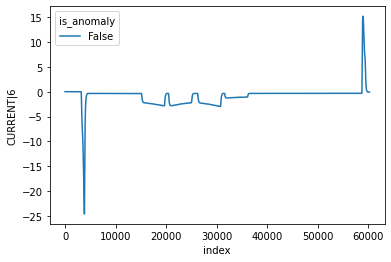

In [ ]:
  file_df =combined_df[combined_df.file_no.isin([1])].reset_index()
  sns.lineplot(data=file_df, x='index' ,y='CURRENT|6', hue='is_anomaly')
  print(len(file_df))
  print(file_df['index'].iloc[0])
  print(file_df['index'].iloc[-1])

25000


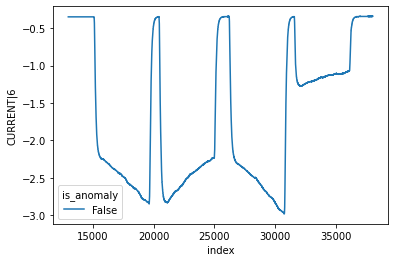

In [ ]:
  file_df =combined_df[combined_df.file_no.isin([1])][13000:38000].reset_index()
  sns.lineplot(data=file_df, x='index' ,y='CURRENT|6', hue='is_anomaly')
  print(len(file_df))
  print(file_df['index'].iloc[0])
  print(file_df['index'].iloc[-1])

### creating clean_df

combining all the clipped dataframes

In [ ]:
clean_df = pd.concat([combined_df[combined_df.file_no.isin([1])][13000:38000], 
                     combined_df[combined_df.file_no.isin([3])][3200:-5000], 
                     combined_df[combined_df.file_no.isin([4])][3200:-500],
                      combined_df[combined_df.file_no.isin([5])][3200:],
                      combined_df[combined_df.file_no.isin([6])][3200:-2000],
                      combined_df[combined_df.file_no.isin([7])][14000:],
                      combined_df[combined_df.file_no.isin([8])][:37000],
                      combined_df[combined_df.file_no.isin([9])][5500:-1500],
                      combined_df[combined_df.file_no.isin([10])][5500:-3000],
                      combined_df[combined_df.file_no.isin([11])][5500:-1500],
                      combined_df[combined_df.file_no.isin([12])][12000:],
                      combined_df[combined_df.file_no.isin([13])][:-3000],
                      combined_df[combined_df.file_no.isin([14])][2500:-2000],
                      combined_df[combined_df.file_no.isin([15])][4500:-2500],
                      combined_df[combined_df.file_no.isin([16])][4500:-2500]], axis=0)
clean_df = clean_df.reset_index(drop=True)

we have to change these parameters in clean_df to make only 12 files ((1 normal + 3 damaged teeth) x 3 tool) 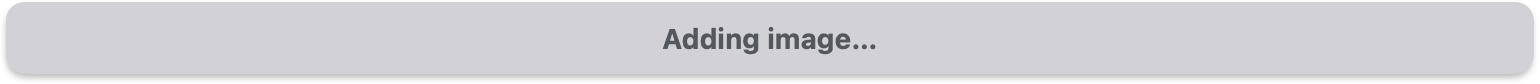

In [ ]:
clean_df.head()

,Unnamed: 0,file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly,CYCLE,CURRENT|1,CURRENT|2,CURRENT|6
0,13000,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871916,0.593018,-0.534912,-0.349121
1,13001,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871917,0.565674,-0.582764,-0.349121
2,13002,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871918,0.558838,-0.616943,-0.349121
3,13003,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871919,0.579346,-0.623779,-0.349121
4,13004,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871920,0.594727,-0.604980,-0.349121


combining the '0 teeth damage' files to one per tool and 3 files for damaged edge per tool, and renaming 

In [ ]:
clean_df['file_no'].mask(clean_df['file_no'] == 3, 1, inplace=True)
clean_df['damage_teeth'].mask(clean_df['file_no'] == 1, 0, inplace=True)

clean_df['file_no'].mask(clean_df['file_no'] == 4, 2, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 5, 3, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 6, 4, inplace=True)

clean_df['file_no'].mask(clean_df['file_no'] == 8, 7, inplace=True)
clean_df['damage_teeth'].mask(clean_df['file_no'] == 7, 0, inplace=True)

clean_df['file_no'].mask(clean_df['file_no'] == 7, 5, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 9, 6, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 10, 7, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 11, 8, inplace=True)

clean_df['file_no'].mask(clean_df['file_no'] == 13, 12, inplace=True)
clean_df['damage_teeth'].mask(clean_df['file_no'] == 12, 0, inplace=True)

clean_df['file_no'].mask(clean_df['file_no'] == 12, 9, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 14, 10, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 15, 11, inplace=True)
clean_df['file_no'].mask(clean_df['file_no'] == 16, 12, inplace=True)

### labelling each tools initial milling operation as 'initial' because their current data is bit different compared to other normal data. This could be because of, we use new slab each time and its possible that the top surface of slab is not that parallel to the ground so when tool tries to cut the material first time it has increase in force on the spindle when going left to right and decrese in the load on spindle when going from right to left.

In [ ]:
clean_df['damage_teeth'][:25000] = '0_1'
clean_df['damage_teeth'][320618:353618] = '0_1'
clean_df['damage_teeth'][630554:663554] = '0_1'

### adding new column 'wear_class' for multi class classification

In [ ]:
clean_df["wear_class"] = np.nan
clean_df['wear_class'].mask(clean_df['damage_teeth'] == '0_1', 4, inplace=True)
clean_df['wear_class'].mask(clean_df['damage_teeth'] == '0', 0, inplace=True)
clean_df['wear_class'].mask(clean_df['damage_teeth'] == '1', 1, inplace=True)
clean_df['wear_class'].mask(clean_df['damage_teeth'] == '2', 2, inplace=True)
clean_df['wear_class'].mask(clean_df['damage_teeth'] == '3', 3, inplace=True)

### clean_df write to Drive

In [ ]:
clean_df = clean_df.drop(columns=['Unnamed: 0'])
clean_df.to_csv('/content/drive/MyDrive/wbk/tool_wear_data/clean_all_tool_wear_current_data.csv')

### clean_df read from Drive

In [ ]:
clean_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/clean_all_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

In [ ]:
clean_df

,Unnamed: 0,file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly,CYCLE,CURRENT|1,CURRENT|2,CURRENT|6,wear_class
0,0,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871916,0.593018,-0.534912,-0.349121,4
1,1,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871917,0.565674,-0.582764,-0.349121,4
2,2,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871918,0.558838,-0.616943,-0.349121,4
3,3,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871919,0.579346,-0.623779,-0.349121,4
4,4,1,tool_d_12_damage_0_1.json,1,12,0_1,False,1871920,0.594727,-0.604980,-0.349121,4
...,...,...,...,...,...,...,...,...,...,...,...,...
945998,945998,12,tool_d_20_damage_3.json,3,20,3,True,5730961,-0.707520,-0.114502,-0.349121,3
945999,945999,12,tool_d_20_damage_3.json,3,20,3,True,5730962,-0.683594,-0.112793,-0.349121,3
946000,946000,12,tool_d_20_damage_3.json,3,20,3,True,5730963,-0.704102,-0.109375,-0.349121,3
946001,946001,12,tool_d_20_damage_3.json,3,20,3,True,5730964,-0.716064,-0.107666,-0.349121,3


### **view clean_df stats**

In [ ]:
clean_df.groupby(['file_no', 'tool','tool_diameter','wear_class','damage_teeth', 'is_anomaly']).count()

Unnamed: 0  \
file_no tool tool_diameter wear_class damage_teeth is_anomaly               
1       1    12            0          0            False           131891   
                           4          0_1          False            25000   
2       1    12            1          1            True             54287   
3       1    12            2          2            True             53754   
4       1    12            3          3            True             55686   
5       2    16            0          0            False           127082   
                           4          0_1          False            33000   
6       2    16            1          1            True             49021   
7       2    16            2          2            True             50638   
8       2    16            3          3            True             50195   
9       3    20            0          0            False           127739   
                           4          0_1          False            33000   
10      3    20            1          1            True             51725   
11      3    20            2          2            True             52219   
12      3    20            3          3            True             50766   

                                                               filename  \
file_no tool tool_diameter wear_class damage_teeth is_anomaly             
1       1    12            0          0            False         131891   
                           4          0_1          False          25000   
2       1    12            1          1            True           54287   
3       1    12            2          2            True           53754   
4       1    12            3          3            True           55686   
5       2    16            0          0            False         127082   
                           4          0_1          False          33000   
6       2    16            1          1            True           49021   
7       2    16            2          2            True           50638   
8       2    16            3          3            True           50195   
9       3    20            0          0            False         127739   
                           4          0_1          False          33000   
10      3    20            1          1            True           51725   
11      3    20            2          2            True           52219   
12      3    20            3          3            True           50766   

                                                                CYCLE  \
file_no tool tool_diameter wear_class damage_teeth is_anomaly           
1       1    12            0          0            False       131891   
                           4          0_1          False        25000   
2       1    12            1          1            True         54287   
3       1    12            2          2            True         53754   
4       1    12            3          3            True         55686   
5       2    16            0          0            False       127082   
                           4          0_1          False        33000   
6       2    16            1          1            True         49021   
7       2    16            2          2            True         50638   
8       2    16            3          3            True         50195   
9       3    20            0          0            False       127739   
                           4          0_1          False        33000   
10      3    20            1          1            True         51725   
11      3    20            2          2            True         52219   
12      3    20            3          3            True         50766   

                                                               CURRENT|1  \
file_no tool tool_diameter wear_class damage_teeth is_anomaly              
1       1    12            0          0            False          131891   
       

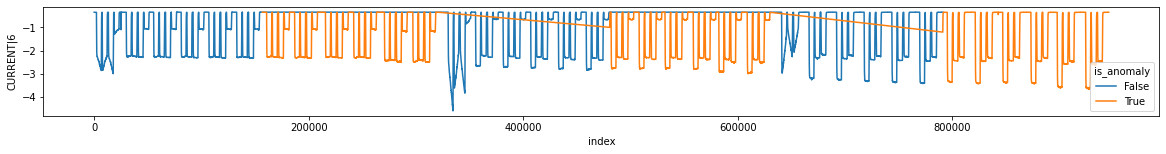

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 2))
sns.lineplot(ax=ax, data=clean_df.reset_index(), x='index', y='CURRENT|6', hue='is_anomaly');

### plot comparison of milling scyle of two tools. to export to latex

In [ ]:
### comparison of motor current data between different tool:

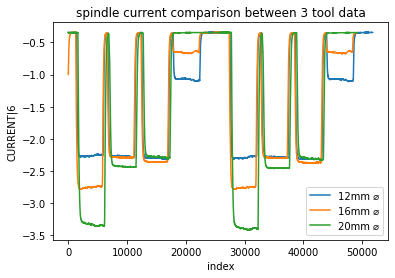

In [ ]:
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([12]))&(clean_df.damage_teeth=='1')][2500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='12mm ⌀');
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([16]))&(clean_df.damage_teeth=='1')].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='16mm ⌀');
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([20]))&(clean_df.damage_teeth=='1')][2500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='20mm ⌀').set(title='spindle current comparison between 3 tool data');

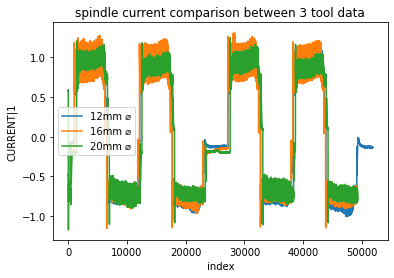

In [ ]:
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([12]))&(clean_df.damage_teeth=='1')][2500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|1', label='12mm ⌀');
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([16]))&(clean_df.damage_teeth=='1')].reset_index(drop=True).reset_index(), x='index', y='CURRENT|1', label='16mm ⌀');
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([20]))&(clean_df.damage_teeth=='1')][2500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|1', label='20mm ⌀').set(title='spindle current comparison between 3 tool data');

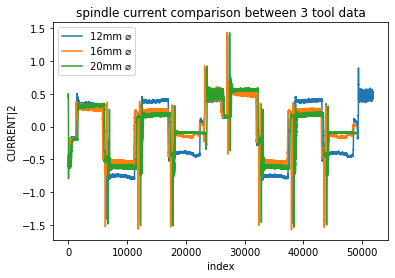

In [ ]:
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([12]))&(clean_df.damage_teeth=='1')][2500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|2', label='12mm ⌀');
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([16]))&(clean_df.damage_teeth=='1')].reset_index(drop=True).reset_index(), x='index', y='CURRENT|2', label='16mm ⌀');
sns.lineplot(data=clean_df[(clean_df.tool_diameter.isin([20]))&(clean_df.damage_teeth=='1')][2500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|2', label='20mm ⌀').set(title='spindle current comparison between 3 tool data');

## Scaling and normalisation:

### standardization 

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(clean_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
clean_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()
#clean_df['CURRENT|6'] = -1 * clean_df['CURRENT|6']

### min max scaling:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(clean_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
clean_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()

### before scaling After scaling comp:

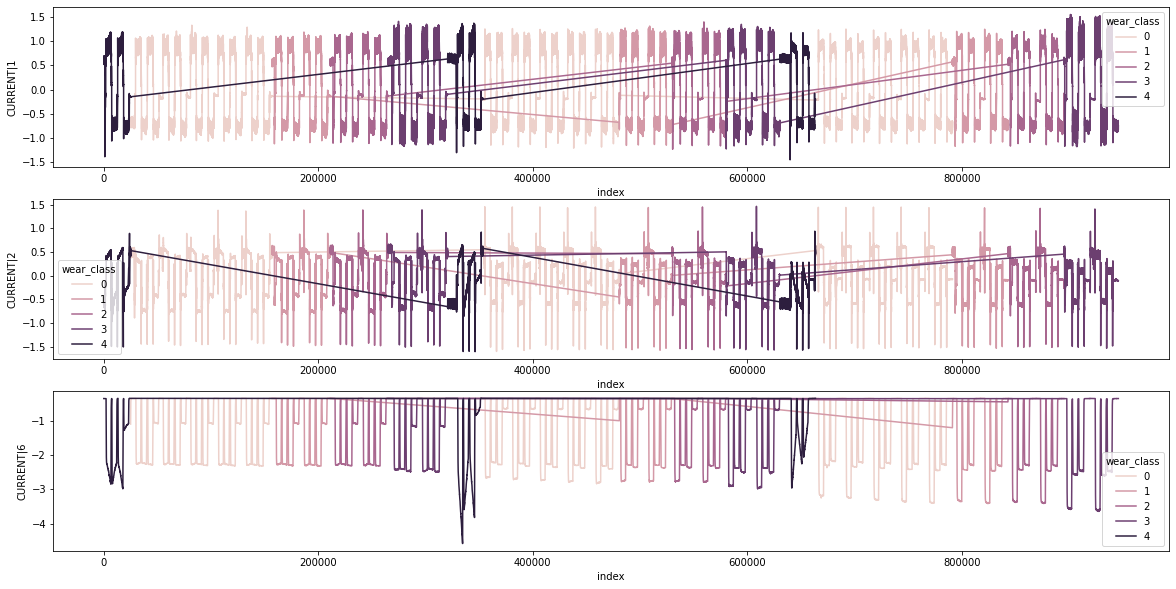

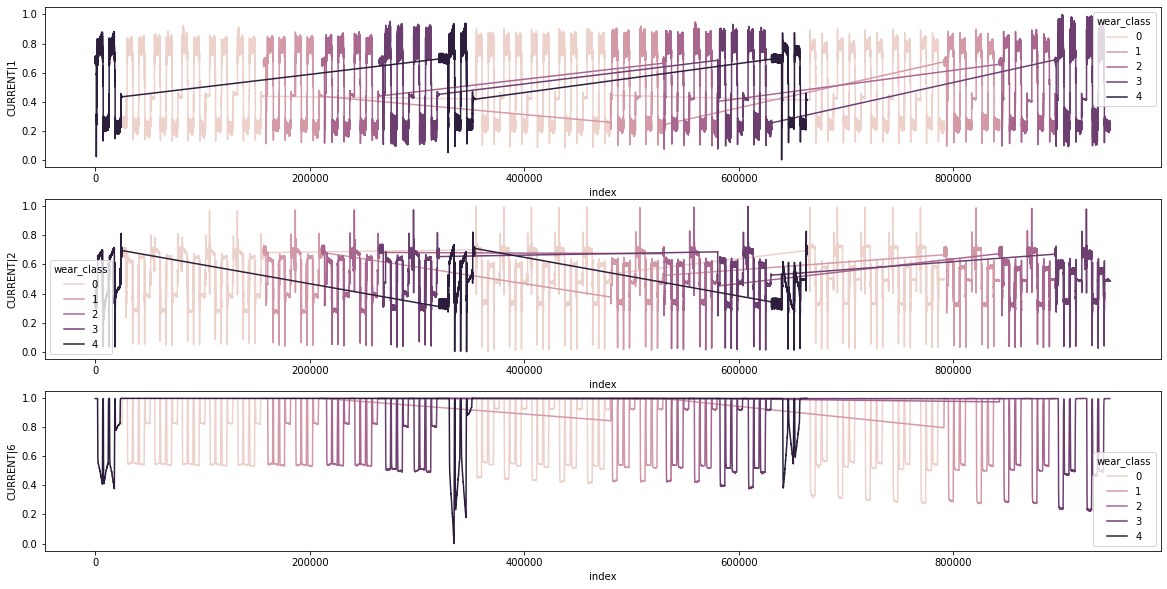

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(20, 10))
sns.lineplot(ax=ax[0], data=clean_df.reset_index(), x='index', y='CURRENT|1', hue='wear_class');
sns.lineplot(ax=ax[1], data=clean_df.reset_index(), x='index', y='CURRENT|2', hue='wear_class');
sns.lineplot(ax=ax[2], data=clean_df.reset_index(), x='index', y='CURRENT|6', hue='wear_class');

## Remove specific type of wear data from Sequences X, y and sf:

In [ ]:
df_seq, X, y = to_sequences(clean_df_list, 300, 300, mix='off', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'

index_True_anomaly = df_seq.index[df_seq['anomaly_or_not'] == True].tolist()
no_of_normal_seq = 1287
slice_list = index_True_anomaly[no_of_normal_seq:]
df_sliced = df_seq.drop(index=slice_list)
X_sliced = np.delete(X, slice_list, 0)
y_sliced = np.delete(y, slice_list, 0)
df_seq, X, y = df_sliced, X_sliced, y_sliced
print(X.shape, y.shape)

## To balance the data: Removing first milling cycles from teeth_damage=1 of each tool

In [ ]:
clean_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/clean_all_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

25725
817293
843017


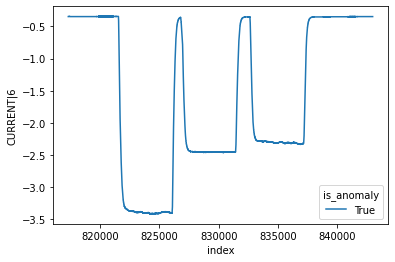

In [ ]:
file_df = clean_df[clean_df.file_no.isin([10])][26000:].reset_index() #2,6,10
sns.lineplot(data=file_df, x='index', y='CURRENT|6', hue='is_anomaly')
print(len(file_df))
print(file_df['index'].iloc[0])
print(file_df['index'].iloc[-1])

### balance_df = removing with index range file: 2, 6. 10 from clean_df

In [ ]:
clean_df[156891:184890]
clean_df[480700:506699]
clean_df[791293:817292]

In [ ]:
balanced_df = clean_df.drop(clean_df.index[list(range(156891,184890)) + list(range(480700,506699)) + list(range(791293,817292))])

In [ ]:
balanced_df = balanced_df.drop(columns=['Unnamed: 0'])
balanced_df = balanced_df[balanced_df.damage_teeth != '0_1']
balanced_df.to_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv')

In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

In [ ]:
balanced_df

,Unnamed: 0,file_no,filename,tool,tool_diameter,damage_teeth,is_anomaly,CYCLE,CURRENT|1,CURRENT|2,CURRENT|6,wear_class
0,25000,1,tool_d_12_damage_0_2_2.json,1,12,0,False,1977794,-0.721191,0.475098,-1.095703,0
1,25001,1,tool_d_12_damage_0_2_2.json,1,12,0,False,1977795,-0.728027,0.454590,-1.087646,0
2,25002,1,tool_d_12_damage_0_2_2.json,1,12,0,False,1977796,-0.700684,0.434082,-1.082275,0
3,25003,1,tool_d_12_damage_0_2_2.json,1,12,0,False,1977797,-0.663086,0.439209,-1.074219,0
4,25004,1,tool_d_12_damage_0_2_2.json,1,12,0,False,1977798,-0.620361,0.459717,-1.066162,0
...,...,...,...,...,...,...,...,...,...,...,...,...
775001,945998,12,tool_d_20_damage_3.json,3,20,3,True,5730961,-0.707520,-0.114502,-0.349121,3
775002,945999,12,tool_d_20_damage_3.json,3,20,3,True,5730962,-0.683594,-0.112793,-0.349121,3
775003,946000,12,tool_d_20_damage_3.json,3,20,3,True,5730963,-0.704102,-0.109375,-0.349121,3
775004,946001,12,tool_d_20_damage_3.json,3,20,3,True,5730964,-0.716064,-0.107666,-0.349121,3


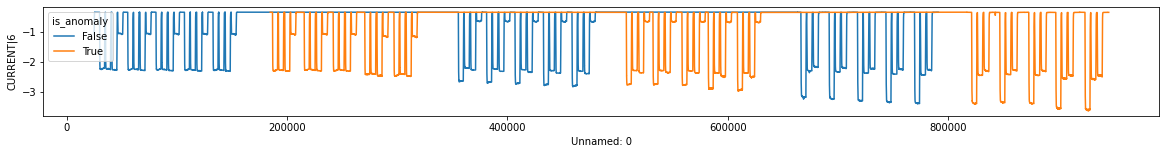

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 2))
sns.lineplot(ax=ax, data=balanced_df.reset_index(), x='Unnamed: 0', y='CURRENT|6', hue='is_anomaly');

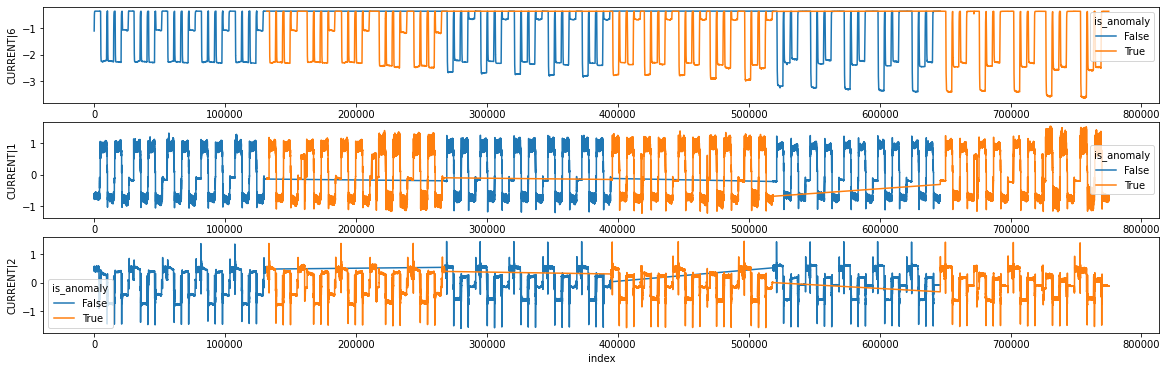

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(20, 6))
sns.lineplot(ax=ax[0], data=balanced_df.reset_index(), x='index', y='CURRENT|6', hue='is_anomaly');
sns.lineplot(ax=ax[1], data=balanced_df.reset_index(), x='index', y='CURRENT|1', hue='is_anomaly');
sns.lineplot(ax=ax[2], data=balanced_df.reset_index(), x='index', y='CURRENT|2', hue='is_anomaly');

In [ ]:
balanced_df = balanced_df[balanced_df.tool.isin([1])] #1,2,3,4,9,10,11,12
balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())
df_seq, X, y = to_sequences(balanced_df_list, 300, 300, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'
print(X.shape, y.shape)
print('----')
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')

(890, 300, 3) (890, 2)
----
total_sequences:  890
wear_class
0    439
1     87
2    179
3    185
Name: wear_class, dtype: int64
------


In [ ]:
balanced_df = balanced_df[balanced_df.tool.isin([2])] #1,2,3,4,9,10,11,12
balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())
df_seq, X, y = to_sequences(balanced_df_list, 300, 300, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'
print(X.shape, y.shape)
print('----')
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')

(834, 300, 3) (834, 2)
----
total_sequences:  834
wear_class
0    423
1     76
2    168
3    167
Name: wear_class, dtype: int64
------


In [ ]:
balanced_df = balanced_df[balanced_df.tool.isin([3])] #1,2,3,4,9,10,11,12
balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())
df_seq, X, y = to_sequences(balanced_df_list, 300, 300, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'
print(X.shape, y.shape)
print('----')
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')

(853, 300, 3) (853, 2)
----
total_sequences:  853
wear_class
0    425
1     85
2    174
3    169
Name: wear_class, dtype: int64
------


In [ ]:
balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())
df_seq, X, y = to_sequences(balanced_df_list, 300, 300, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'

In [ ]:
df_seq

,file_no,anomaly_or_not,wear_class,CURRENT|6,CURRENT|1,CURRENT|2
0,8,True,3,"[-2.489502, -2.486816, -2.489502, -2.489502, -...","[0.832275, 0.861328, 1.052734, 1.09375, 0.9758...","[0.186279, 0.220459, 0.230713, 0.276855, 0.199..."
1,1,False,0,"[-1.00708, -1.017822, -1.03125, -1.041992, -1....","[-0.623779, -0.663086, -0.736572, -0.712646, -...","[-0.765625, -0.79126, -0.781006, -0.779297, -0..."
2,7,True,2,"[-2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2....","[1.119385, 1.092041, 0.900635, 0.869873, 0.992...","[0.297363, 0.264893, 0.292236, 0.251221, 0.314..."
3,2,True,1,"[-0.362549, -0.362549, -0.362549, -0.362549, -...","[-0.700684, -0.704102, -0.698975, -0.661377, -...","[0.073486, 0.078613, 0.078613, 0.078613, 0.078..."
4,7,True,2,"[-2.376709, -2.376709, -2.376709, -2.376709, -...","[1.172363, 1.086914, 0.898926, 0.910889, 1.064...","[0.225586, 0.240967, 0.234131, 0.217041, 0.266..."
...,...,...,...,...,...,...
2572,5,False,0,"[-0.655273, -0.657959, -0.657959, -0.655273, -...","[-0.719482, -0.729736, -0.685303, -0.654541, -...","[-0.146973, -0.136719, -0.140137, -0.143555, -..."
2573,5,False,0,"[-2.639893, -2.642578, -2.642578, -2.642578, -...","[0.716064, 0.852783, 1.003174, 0.977539, 0.825...","[0.522949, 0.581055, 0.567383, 0.533203, 0.534..."
2574,5,False,0,"[-2.271973, -2.274658, -2.274658, -2.271973, -...","[-0.693848, -0.618652, -0.630615, -0.680176, -...","[-0.618652, -0.591309, -0.582764, -0.563965, -..."
2575,1,False,0,"[-2.301514, -2.301514, -2.301514, -2.304199, -...","[0.998047, 0.873291, 0.844238, 0.900635, 0.982...","[0.391357, 0.398193, 0.399902, 0.411865, 0.393..."


In [ ]:
import plotly.express as px

df = balanced_df.reset_index() #px.data.tips()
fig = px.line(df, x="index", y="CURRENT|6", color="wear_class") #, barmode="group"
fig.show()

### data comparison plots

In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

#### Wear class comparision of all 3 tool

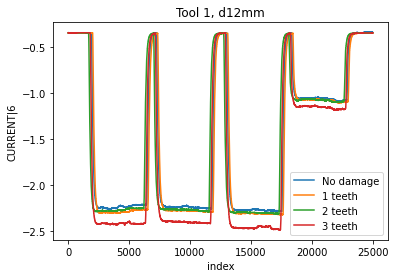

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='0')][3000:28000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='No damage');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='1')][:25000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='1 teeth');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='2')][2800:27800].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='2 teeth');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='3')][3900:28900].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='3 teeth').set(title='Tool 1, d12mm');

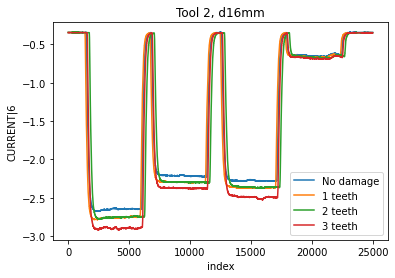

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='0')][500:25500].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='No damage');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='1')][:25000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='1 teeth');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='2')][800:25800].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='2 teeth');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='3')][500:25500].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='3 teeth').set(title='Tool 2, d16mm');

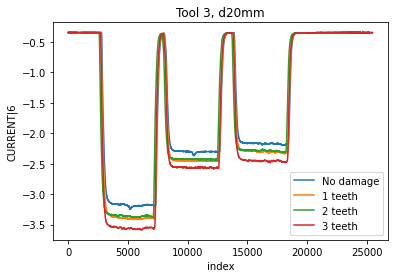

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='0')][200:25500].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='No damage');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='1')][1500:25000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='1 teeth');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='2')][1500:25800].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='2 teeth');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='3')][:25500].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='3 teeth').set(title='Tool 3, d20mm');

#### same wear condition per Tool 

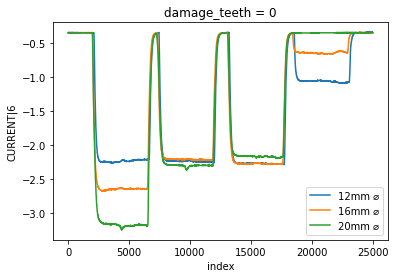

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='0')][2800:27800].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='12mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='0')][:25000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='16mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='0')][1000:26000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='20mm ⌀').set(title='damage_teeth = 0');

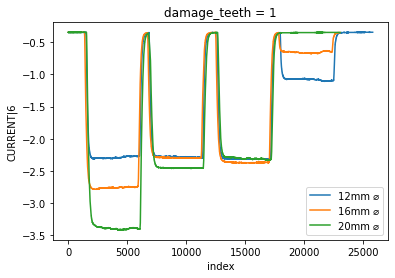

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='1')][500:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='12mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='1')].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='16mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='1')][2700:].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='20mm ⌀').set(title='damage_teeth = 1');

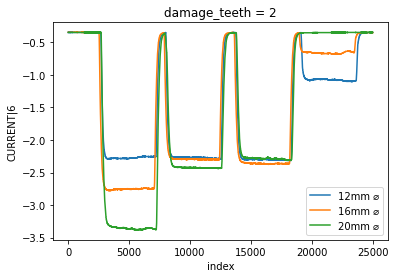

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='2')][1800:26800].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='12mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='2')][:25000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='16mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='2')][1400:26400].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='20mm ⌀').set(title='damage_teeth = 2');

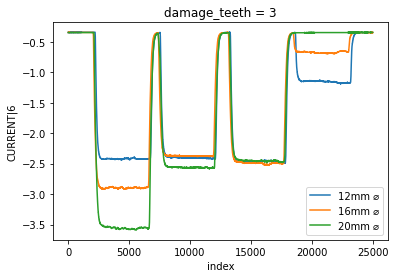

In [ ]:
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([12]))&(balanced_df.damage_teeth=='3')][3500:28500].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='12mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([16]))&(balanced_df.damage_teeth=='3')][:25000].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='16mm ⌀');
sns.lineplot(data=balanced_df[(balanced_df.tool_diameter.isin([20]))&(balanced_df.damage_teeth=='3')][600:25600].reset_index(drop=True).reset_index(), x='index', y='CURRENT|6', label='20mm ⌀').set(title='damage_teeth = 3');

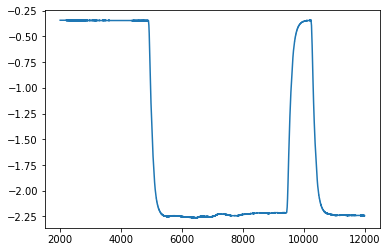

In [ ]:
plt.plot(balanced_df['CURRENT|6'][2000:12000])

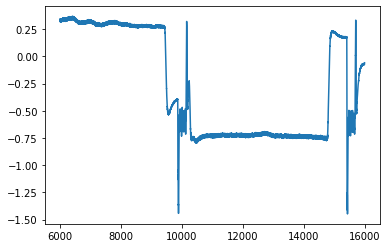

In [ ]:
plt.plot(balanced_df['CURRENT|2'][6000:16000])

### Data distribution plots: Mean, Deviation:

mean:  -1.545867285457145
std:  1.0228190315903025


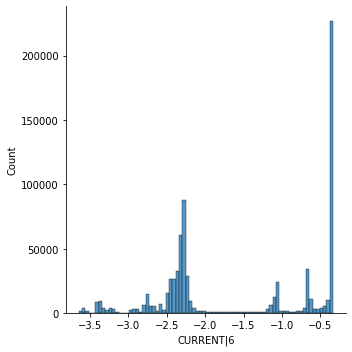

In [ ]:
sns.displot(balanced_df, x="CURRENT|6")

from scipy.stats import norm
import statistics
mean = statistics.mean(balanced_df["CURRENT|6"])
std = statistics.stdev(balanced_df["CURRENT|6"])
print('mean: ',mean)
print('std: ',std)

mean:  0.051271780690730136
std:  0.7611345298329557


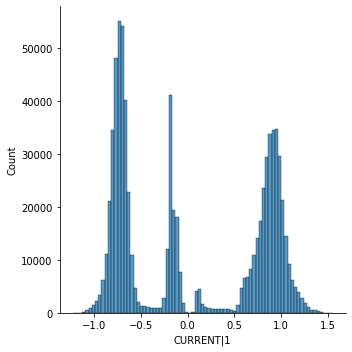

In [ ]:
sns.displot(balanced_df, x="CURRENT|1")

mean = statistics.mean(balanced_df["CURRENT|1"])
std = statistics.stdev(balanced_df["CURRENT|1"])
print('mean: ',mean)
print('std: ',std)

mean:  0.0027437579309063415
std:  0.4390789770058616


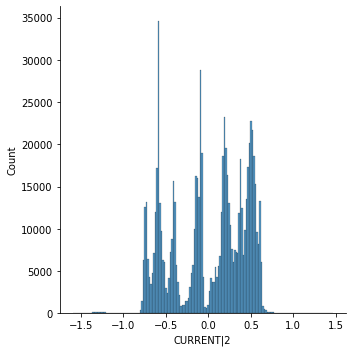

In [ ]:
sns.displot(balanced_df, x="CURRENT|2")

mean = statistics.mean(balanced_df["CURRENT|2"])
std = statistics.stdev(balanced_df["CURRENT|2"])
print('mean: ',mean)
print('std: ',std)

# Train-Test Split:

min-max normalisation and then split:

In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()

balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())

df_seq, X, y = to_sequences(balanced_df_list, 300, 300, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'